# Density based clustering

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

quant = pd.read_csv("ravdess_quantitative.csv")
categ = pd.read_csv("ravdess_categorical.csv")

First, a normalization is needed.

In [106]:
from sklearn.preprocessing import QuantileTransformer, StandardScaler, MinMaxScaler
from sklearn.metrics import mutual_info_score
scaler = MinMaxScaler()
X = scaler.fit_transform(quant.values)

It is necessary to embed the dataset in a lower-dimensional space. I choose to use ISOMAP

## DBSCAN

In [104]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

N = 20
sil = np.zeros(N)
label_number = np.zeros(N)

epsilons = np.linspace(0.000001,1, N)
for i,eps in enumerate(epsilons):
    clustering = DBSCAN(eps=eps, min_samples=20).fit(X)
    if len(np.unique(clustering.labels_)) > 1:
        sil[i] = silhouette_score(X, clustering.labels_)
        label_number[i] = len(np.unique(clustering.labels_))
    else:
        sil[i] = 0
        label_number[i] = 1
        
    if np.all(clustering.labels_==-1):
            label_number[i] = -1

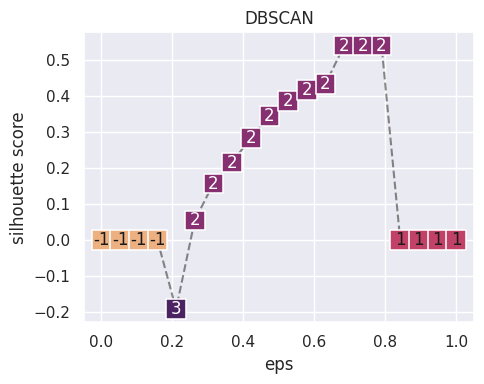

In [105]:
dummy_df = pd.DataFrame()
dummy_df["eps"] = epsilons
dummy_df["silhouette score"] = sil
dummy_df["n_labels"] = label_number

fig, ax = plt.subplots(figsize=(5,4))
sns.lineplot(data=dummy_df, x="eps", y="silhouette score", alpha=0.5, color= "k" , ls="--", zorder=1)
sns.scatterplot(data=dummy_df, x="eps", y="silhouette score", hue="n_labels", s=200, palette="flare", legend=False, marker="s", zorder=2)

for i, record in dummy_df.iterrows():
    if record["n_labels"] > 1:
        color = "white"
    else:
        color="k"
    plt.annotate(str(int(record["n_labels"])), (record["eps"], record["silhouette score"]), ha="center", va="center", color=color, zorder=3)
plt.title("DBSCAN")
plt.savefig("DBSCAN_sil.pdf")

/tmp/ipykernel_82281/2623234504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mi_df = mi_df.append(pd.DataFrame({"category": [cat], "mutual info": [mutual_info_score(categ[cat], clustering.labels_)] }), ignore_index=True)
/tmp/ipykernel_82281/2623234504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mi_df = mi_df.append(pd.DataFrame({"category": [cat], "mutual info": [mutual_info_score(categ[cat], clustering.labels_)] }), ignore_index=True)
/tmp/ipykernel_82281/2623234504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mi_df = mi_df.append(pd.DataFrame({"category": [cat], "mutual info": [mutual_info_score(categ[cat], clustering.labels_)] }), ignore_index=True)
/tmp/ipykernel_82281/2623234504.py:6: FutureWarni

,category,mutual info
0,vocal_channel,0.000364
1,emotion,0.000765
2,emotional_intensity,0.000315
3,statement,0.000283
4,repetition,0.000283
5,actor,0.000317
6,sex,0.000290


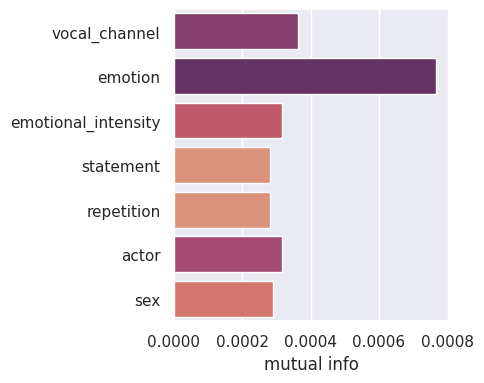

In [139]:
clustering = DBSCAN(eps=0.8, min_samples=20).fit(X)

mi_df= pd.DataFrame(columns = ["category", "mutual info"])

for cat in categ.columns:
    mi_df = mi_df.append(pd.DataFrame({"category": [cat], "mutual info": [mutual_info_score(categ[cat], clustering.labels_)] }), ignore_index=True)

display(mi_df)
fig, ax = plt.subplots(figsize=(5,4))
sns.barplot(data=mi_df, x ="mutual info", y="category", hue="mutual info", dodge=False, palette="flare", width=.8)
plt.ylabel("")
plt.legend([],[], frameon=False)
plt.savefig("DBSCAN_MI.pdf")


## OPTICS

In [102]:
from sklearn.cluster import OPTICS

X = MinMaxScaler().fit_transform(quant.values)
minsamp = np.arange(5, 20,2)
N = len(minsamp)
sil = np.zeros(N)
label_number = np.zeros(N)

for i,ms in enumerate(minsamp):
    clustering = OPTICS(min_samples=ms).fit(X)
    if len(np.unique(clustering.labels_)) > 1:
        sil[i] = silhouette_score(X, clustering.labels_)
        label_number[i] = len(np.unique(clustering.labels_))
    else:
        sil[i] = 0
        label_number[i] = 1
    if np.all(clustering.labels_==-1):
            label_number[i] = -1


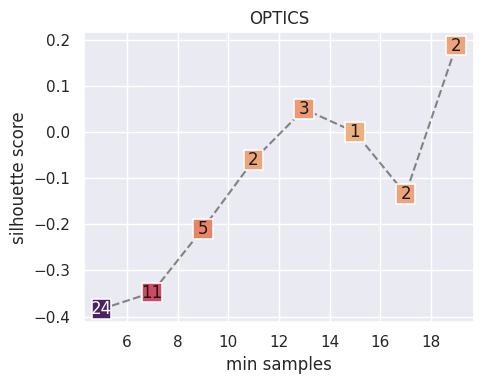

In [103]:
dummy_df = pd.DataFrame()
dummy_df["min samples"] = minsamp
dummy_df["silhouette score"] = sil
dummy_df["n_labels"] = label_number

fig, ax = plt.subplots(figsize=(5,4))
sns.lineplot(data=dummy_df, x="min samples", y="silhouette score", alpha=0.5, color= "k" , ls="--", zorder=1)
sns.scatterplot(data=dummy_df, x="min samples", y="silhouette score", hue="n_labels", s=200, palette="flare", legend=False, marker="s", zorder=2)

for i, record in dummy_df.iterrows():
    if record["n_labels"] > 15:
        color = "white"
    else:
        color="k"
    plt.annotate(str(int(record["n_labels"])), (record["min samples"], record["silhouette score"]), ha="center", va="center", color=color, zorder=3)
plt.title("OPTICS")
plt.savefig("OPTICS_sil.pdf")

/tmp/ipykernel_82281/4114957395.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mi_df = mi_df.append(pd.DataFrame({"category": [cat], "mutual info": [mutual_info_score(categ[cat], clustering.labels_)] }), ignore_index=True)
/tmp/ipykernel_82281/4114957395.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mi_df = mi_df.append(pd.DataFrame({"category": [cat], "mutual info": [mutual_info_score(categ[cat], clustering.labels_)] }), ignore_index=True)
/tmp/ipykernel_82281/4114957395.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mi_df = mi_df.append(pd.DataFrame({"category": [cat], "mutual info": [mutual_info_score(categ[cat], clustering.labels_)] }), ignore_index=True)
/tmp/ipykernel_82281/4114957395.py:6: FutureWarni

,category,mutual info
0,vocal_channel,0.000459
1,emotion,0.004838
2,emotional_intensity,0.000695
3,statement,0.000744
4,repetition,0.000009
5,actor,0.005600
6,sex,0.000003


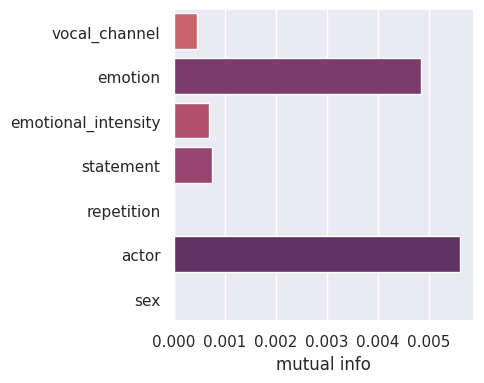

In [138]:
clustering = DBSCAN(min_samples=20).fit(X)

mi_df= pd.DataFrame(columns = ["category", "mutual info"])

for cat in categ.columns:
    mi_df = mi_df.append(pd.DataFrame({"category": [cat], "mutual info": [mutual_info_score(categ[cat], clustering.labels_)] }), ignore_index=True)

display(mi_df)
fig, ax = plt.subplots(figsize=(5,4))
sns.barplot(data=mi_df, x ="mutual info", y="category", hue="mutual info", dodge=False, palette="flare", width=.8)
plt.ylabel("")
plt.legend([],[], frameon=False)
plt.savefig("OPTICS_MI.pdf")

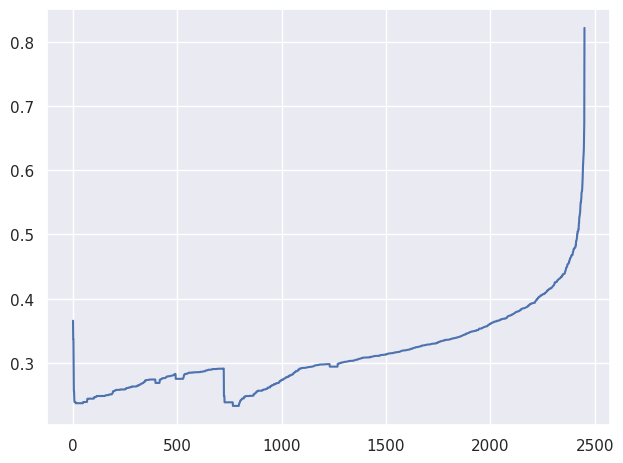

In [72]:
reachability = clustering.reachability_[clustering.ordering_]
plt.plot(reachability)